In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import Dataset, DataLoader
import time
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from datetime import datetime
import os
import matplotlib.pyplot as plt

In [2]:
train_transform = transforms.Compose(
    [
     transforms.Resize((32, 32)), # MNIST  is 28x28 for conveniencewe will make it 32x32
     transforms.RandomRotation(degrees=15),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
     ])

val_transform = transforms.Compose(
    [
     transforms.Resize((32, 32)),
     transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))
     ])


np.random.seed(0)
torch.manual_seed(0)
random.seed(0)

train_set = datasets.MNIST(root = ".",train=True,
                                        download=True, transform=train_transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128,
                                          shuffle=True, num_workers=0)

val_set = datasets.MNIST(root = ".",train=False,
                                       download=True, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128,
                                         shuffle=False, num_workers=0)

train_set_size = len(train_set)
print("Train set size:", train_set_size)
val_set_size = len(val_set)
print("Val set size:", val_set_size)

100%|██████████| 9912422/9912422 [00:00<00:00, 139815145.33it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 120055197.05it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 36783330.21it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21998301.12it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Train set size: 60000
Val set size: 10000


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # checks if there is gpu available

In [4]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print("Sample image shape ", images.shape)
print("Sample labels shape", labels.shape)

Sample image shape  torch.Size([128, 1, 32, 32])
Sample labels shape torch.Size([128])


In [5]:
def imshow(img):
   img = (img + 1) / 2     # unnormalize
   img = img.numpy()
   plt.imshow(np.transpose(img, (1, 2, 0)))
   plt.show()

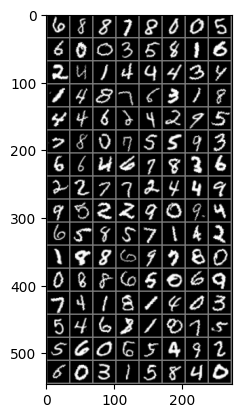

In [6]:
imshow(torchvision.utils.make_grid(images))

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_l1 = nn.Sequential(
            nn.Conv2d(1, 16, 3,stride=1,padding=0),
            nn.MaxPool2d(2,stride=2),
            nn.ReLU()
        )
        self.conv_l2 = nn.Sequential(
            nn.Conv2d(16, 32, 3,stride=1,padding=2),
            nn.MaxPool2d(2,stride=2),
            nn.ReLU()
        )
        self.conv_l3 = nn.Sequential(
            nn.Conv2d(32, 32, 3,stride=1,padding=2),
            nn.MaxPool2d(2,stride=2),
            nn.ReLU()
        )

        self.fc = nn.Sequential(nn.Linear(5*5*32, 256),
                                 nn.ReLU(),
                                 nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.conv_l1(x)
        x = self.conv_l2(x)
        x = self.conv_l3(x)
        x = x.view(-1, 5 * 5 * 32)
        x = self.fc(x)

        return x

In [8]:
model = Net()

dataiter = iter(train_loader)
images, labels = next(dataiter)
out = model(images)
print(out.shape)

torch.Size([128, 10])


In [10]:
def train_model(
    model, criterion, optimizer, num_epochs=10, checkp_epoch=0, scheduler=None,log=False,save_every=5
):
    since = time.time()

    if log is True:
        my_file = open(plot_file, "a")

    pbar = tqdm(range(checkp_epoch, num_epochs))
    for epoch in pbar:

        model.train()

        running_loss = 0.0
        running_corrects = 0

        for sample in train_loader:
            inputs, labels = sample
            batch_size = inputs.size(0)
            inputs = inputs.to(device)
            labels = labels.to(device)


            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()
                if scheduler != None:
                    scheduler.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        train_loss = running_loss / train_set_size
        train_acc = running_corrects.double().item() / train_set_size

        model.eval()

        running_loss = 0.0
        running_corrects = 0

        with torch.no_grad():
            for sample in val_loader:
                inputs, labels = sample
                batch_size = inputs.size(0)
                inputs = inputs.to(device)
                labels = labels.to(device)


                with torch.set_grad_enabled(False):
                  outputs = model(inputs)
                  _ , preds = torch.max(outputs, 1)
                  loss = criterion(outputs, labels)

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        val_loss = running_loss / val_set_size
        val_acc = running_corrects.double().item() / val_set_size
        if log is True:
            if epoch % save_every == 0 or epoch == num_epochs-1:
              torch.save(
                  {
                      "epoch": epoch,
                      "model_state_dict": model.state_dict(),
                      "optimizer_state_dict": optimizer.state_dict(),
                  },
                  checkpoint_file + "_epoch_{}.pt".format(epoch),
              )

            log_data = {
                "epoch": epoch,
                "train_loss": train_loss,
                "val_loss": val_loss,
                "train_acc":train_acc,
                "val_acc":val_acc

            }
            df = pd.DataFrame(log_data,index=[0])
            if epoch==0:
                df.to_csv(my_file,index=False,mode="a")
            else:
                df.to_csv(my_file, header=False,index=False,mode="a")

        pbar.set_description("train acc {:.3} loss {:.4} val acc {:.3} loss {:.4}".format(train_acc,train_loss,val_acc,val_loss))

    time_elapsed = time.time() - since
    print(
        "Training complete in {:.0f}m {:.0f}s".format(
            time_elapsed // 60, time_elapsed % 60
        )
    )

    return model


model = Net().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)# , weight_decay=1e-4)

now = datetime.now()

checkpoint_file = "mnist" + now.strftime("%d_%m_%Y_%H:%M:%S")
plot_file = "mnist" + now.strftime("%d_%m_%Y_%H:%M:%S") + ".csv"

num_epochs = 11

model = train_model(
    model, criterion, optimizer, num_epochs=num_epochs, scheduler=None, log = True,
)

train acc 0.977 loss 0.0725 val acc 0.985 loss 0.04604: 100%|██████████| 11/11 [04:25<00:00, 24.09s/it]

Training complete in 4m 25s


In [11]:
csv_data = pd.read_csv("mnist.csv")
csv_data.head()

,epoch,train_loss,val_loss,train_acc,val_acc
0,0,1.000077,0.313240,0.714883,0.9129
1,1,0.281790,0.172702,0.917617,0.9487
2,2,0.189913,0.127934,0.942850,0.9591
3,3,0.150621,0.098008,0.953800,0.9701
4,4,0.126874,0.084141,0.961133,0.9740


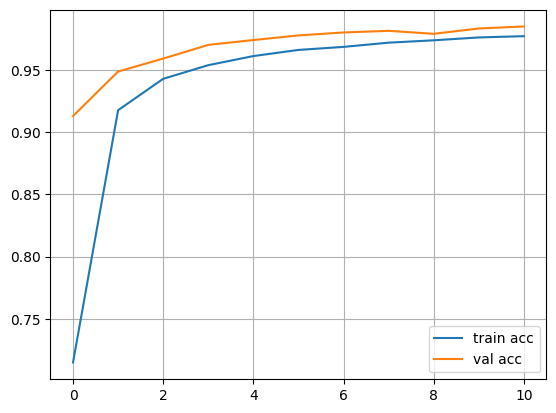

In [12]:
plt.plot(csv_data["train_acc"])
plt.plot(csv_data["val_acc"])
plt.grid()
plt.legend(["train acc","val acc"])
plt.show()

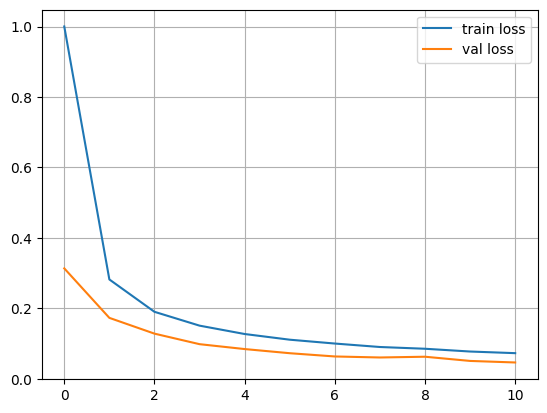

In [13]:
plt.plot(csv_data["train_loss"])
plt.plot(csv_data["val_loss"])
plt.grid()
plt.legend(["train loss","val loss"])
plt.show()